In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier as KNN

In [2]:
df = pd.read_csv("train/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")

In [3]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength', 'quadrant'])

# we want to predict the quadrant:
y = df['quadrant']

In [4]:
#create tags_dataframe:
X_tags=pd.DataFrame()
X_tags['id']=df['id']


#extract piece_id and pianist to later allow by piece/pianist/both cross validation
def extractPianist(x):
    return x[0:2]
def extract_piece_id(x):
    return x[3:5]
def extract_snippet_number(x):
    return x[6:9]

#get relevant information from dataframe
X_tags['Piece_id']=X_tags['id'].apply(extract_piece_id)
X_tags['Snippet_number']=X_tags['id'].apply(extract_snippet_number)
X_tags['class']=df['quadrant']

#get list of pianists and pieces!
piece_list=list(set(X_tags['Piece_id']))

In [5]:
#get distribution of classes per piece
piece_dist_list=[]
piece_dist_list_perecent=[]
for piece in piece_list:
    mylist=[]
    for i in range(4):
        mylist.append(len(X_tags.loc[(X_tags['Piece_id'] == piece) & (X_tags['class']==i+1)]))
    piece_dist_list.append(mylist)
    mylist=[element/sum(mylist) for element in mylist]
    piece_dist_list_perecent.append(mylist)
piece_dist_list

[[18, 4, 0, 7],
 [0, 0, 158, 0],
 [22, 0, 0, 13],
 [6, 24, 0, 0],
 [22, 0, 0, 0],
 [35, 0, 0, 0],
 [26, 0, 0, 0],
 [8, 0, 0, 74],
 [5, 0, 4, 19],
 [0, 7, 37, 0],
 [0, 0, 32, 44],
 [0, 0, 142, 0],
 [11, 0, 0, 59],
 [0, 54, 11, 0],
 [0, 0, 195, 0],
 [36, 0, 0, 0],
 [0, 42, 12, 0],
 [0, 0, 194, 0],
 [14, 33, 0, 0],
 [5, 21, 9, 0],
 [0, 22, 136, 0],
 [0, 0, 67, 12],
 [0, 0, 127, 0],
 [0, 16, 60, 0],
 [59, 0, 0, 30],
 [0, 16, 62, 0],
 [33, 0, 0, 43],
 [53, 0, 0, 0],
 [22, 0, 0, 48],
 [37, 0, 0, 0],
 [32, 0, 0, 0],
 [13, 0, 0, 26],
 [8, 0, 0, 45],
 [8, 0, 19, 52],
 [0, 26, 21, 8],
 [0, 9, 94, 0]]

In [37]:
#selected_list=[,'15','18','29','09','18','29','03','31','22']#yes adding piece indices multiple times 
# does do upsampling
selected_list=['14', '03', '34',  '28', '29',  '21','38','11', 
               '25',  '26', '02', '41', '15',  '36', '16', '19', '20', 
               '27', '39', '30', '24', '04', '12', '22', '35', '47', '18', 
               '45', '37']#emoved:'08',   
Train_Snippets=[]
#and create horizontal splits:
for i,piece in enumerate(selected_list):
    vetrical_mask_train=np.zeros(0).astype(int)

    mask= X_tags[X_tags['Piece_id']==selected_list[i]].index.values.astype(int)
    vetrical_mask_train=np.concatenate((vetrical_mask_train,mask), axis=0)

    #print(vetrical_mask_test)
    #print(vetrical_mask_train)
    trainIndices=vetrical_mask_train
    
    [Train_Snippets.append(index) for index in trainIndices]


In [38]:
#double_checking:
temp_df=X_tags.iloc[Train_Snippets]

#get class distributions
class_dist_list=[]
for i in range(4):
    class_dist_list.append(len(temp_df.loc[temp_df['class']==i+1]))
print(class_dist_list)
max_snippets= max(class_dist_list)
print(f'maximum snippets { max(class_dist_list)}')

[371, 182, 1154, 380]
maximum snippets 1154


In [39]:
#creating inverse test set:
print(len(X_tags))
#create_indices
indices=[]
for i in range(len(X_tags)):
    indices.append(i)

#masking the right inidices:
temp_test = np.ones(len(X_tags), np.bool)
temp_test[Train_Snippets] = 0




Test_Snippets=[b for a, b in zip(temp_test, indices) if a]
org_Test_Snippets=Test_Snippets

print(len(Test_Snippets))

2607
520


<ipython-input-39-4f0453ca7d8a>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_test = np.ones(len(X_tags), np.bool)


In [156]:
X_test=X.iloc[Test_Snippets]
X_train=X.iloc[Train_Snippets]

y_train = df['quadrant'].values
y_train=np.float32(y_train)

y_test=y_train[Test_Snippets]
y_train=y_train[Train_Snippets]


In [158]:
num_selceted=50
selector=PCA(n_components=num_selceted) #SelectKBest(mutual_info_classif, k=num_selceted)
X_new = selector.fit_transform(X_train, y_train)




In [159]:
selector.get_params(deep=True)

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 50,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

#### Now we use SelectKBest + TSNE +KNN for prediction:

In [160]:
sel_X_train=selector.transform(X_train)
sel_X_test=selector.transform(X_test)

In [161]:
X_Stacked=np.vstack((sel_X_train,sel_X_test))
y_stacked=np.zeros(len(y_train)+len(y_test))

for i in range(len(y_train)+len(y_test)):
    if i<len(y_train):
        y_stacked[i]=y_train[i]
    else:
        y_stacked[i]=y_test[i-len(y_train)]+4


In [162]:
tsne=TSNE()
proj=tsne.fit_transform(X_Stacked,y_stacked)


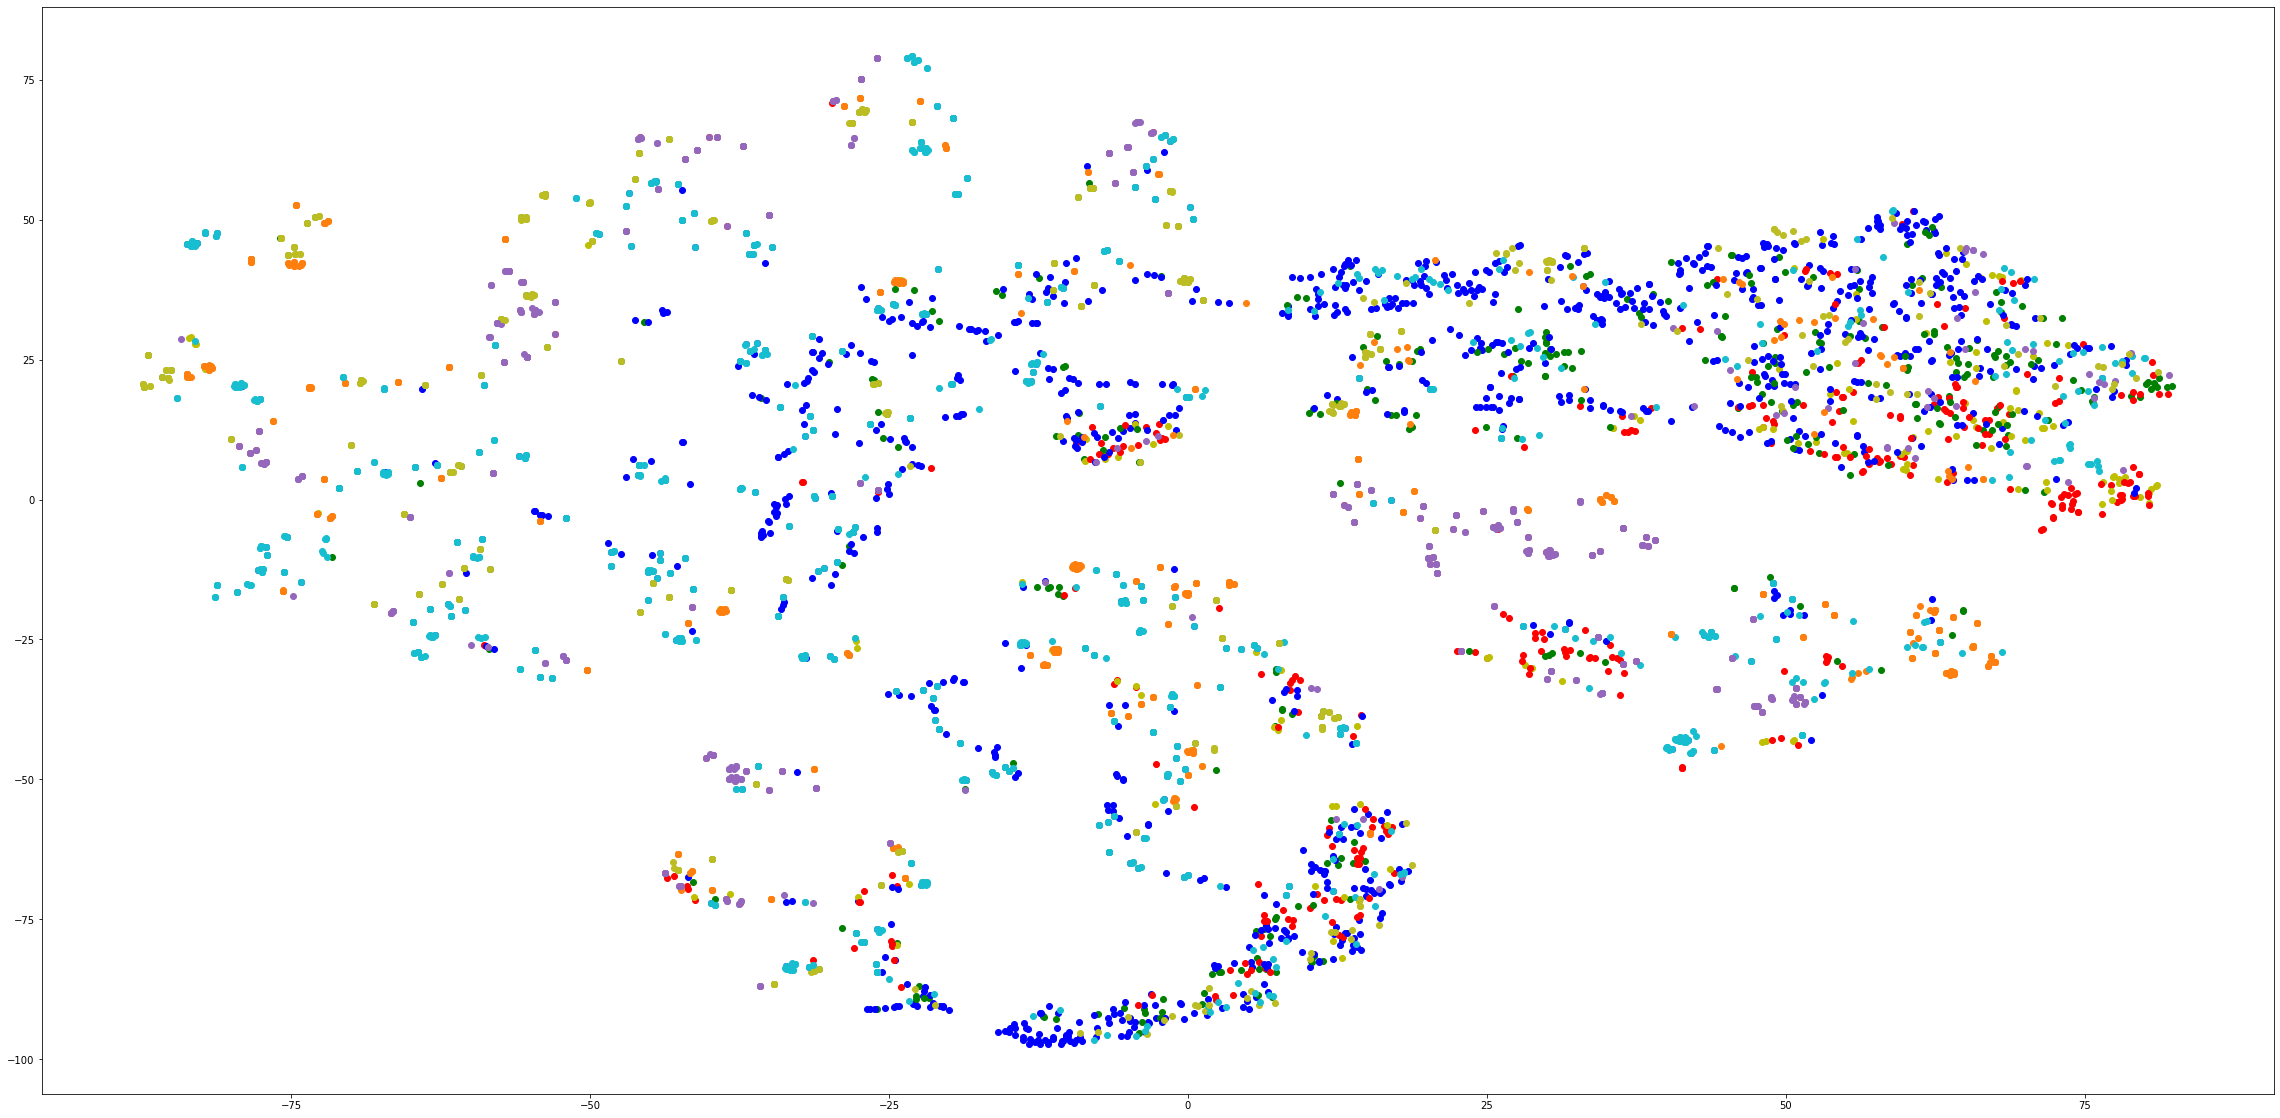

In [163]:
plt.figure(figsize=(40,20))
colors = ['r','y','b','g','tab:purple','tab:orange','tab:cyan','tab:olive']
for j in range(len(proj)):
            plt.scatter(proj[j][0], proj[j][1],color=colors[y_stacked[j].astype(int)-1])


plt.show()

In [164]:
#need to seperate this proection into X_train and X_test
projected_train=np.zeros((len(X_train),num_selceted))
projected_test=np.zeros((len(X_test),num_selceted))
for i in range(len(X_train)+len(X_test)):
    if i<len(X_train):
        projected_train[i]=X_Stacked[i]
    else:
        projected_test[i-len(X_train)]=X_Stacked[i]


#### to get a more accurate prediction we need to upsample the test set to the original distribution!

In [165]:
#creating equal to original distribution in TestSet! using upsampling

#all snippets that are in the training set:
temp_df=X_tags.iloc[org_Test_Snippets]
org_temp_df=X_tags

#get class distributions
test_class_dist=[]
org_class_dist=[]

total_difference=0
for i in range(4):
    org_class_dist.append(len(org_temp_df.loc[org_temp_df['class']==i+1]))
    test_class_dist.append(len(temp_df.loc[temp_df['class']==i+1]))
    total_difference+=(org_class_dist[i]-test_class_dist[i])
print(org_class_dist)
print(test_class_dist)
max_snippets= max(test_class_dist)
print(f'maximum snippets { max(test_class_dist)}')

#randomly duplicate snippets in small classes to reach even distribution:

#generate a mask:
mask=np.array(range(len(projected_test)))
additional_test_set=[]
additional_y_set=[]
print(total_difference)

additional_test=np.array((len(projected_test)))

for i in range(4):
    #print(org_class_dist[i]-test_class_dist[i])
    dup_num= org_class_dist[i]-test_class_dist[i]
    if(dup_num>0):
        temp_list=np.random.choice(mask, size=dup_num, replace=True)
        #print(temp_list)
        [additional_test_set.append(projected_test[index]) for index in temp_list]
        [additional_y_set.append(y_test[index]) for index in temp_list]

additional_test_set=np.array(additional_test_set)
print(len(additional_test_set))
print(len(additional_y_set))

[473, 274, 1380, 480]
[537, 472, 1140, 458]
maximum snippets 1140
0
262
262


In [166]:
X_Stacked=np.vstack((projected_test,additional_test_set))
y_stacked=np.zeros(len(y_test)+len(additional_y_set))

for i in range(len(y_test)+len(additional_y_set)):
    if i<len(y_test):
        y_stacked[i]=y_test[i]
    else:
        y_stacked[i]=additional_y_set[i-len(y_test)]

In [173]:
knn=KNN(n_neighbors=1)
knn.fit(projected_train,y_train.astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [174]:
knn.score(X_Stacked,y_stacked.astype(int))

0.7594980829557337